# BDTT Coursework 

## Pyspark Implementation (2/4)

### Name :        Karishma Prasad 
### Student ID :  @00572026

#### Invoke Jupyter Notebook using the following code
pyspark --jars /home/cloudera/Downloads/commons-csv-1.4.jar,/home/cloudera/Downloads/spark-csv_2.10-1.5.0.jar

#### Aim:-
The aim of the current study is to analyse and visualise the real-life medical data provided using the Big data tools and techniques. 
The current study involves mainly two implementations:- 1) SQL using Hive/Impala, 2) Spark using Pyspark.

Current Jupyter notebook comprises of Spark implementation with RDD and Dataframes

##### This coursework comprises of the following :- 
* 1. Impala bash script
* 2. Jupyter Notebook - Pyspark Implementation (RDD and Dataframe)
* 3. Jupyter Notebook - Impala visualisation 
* 4. Databricks Notebook

## 1. Setting Up the Directories  

In [1]:
assert sc.version == "1.6.0", "This notebook must be run on the VM (use of Spark 1.x is assumed)"

--> Check if the data exists in 'Downloads' file

In [2]:
assert os.path.exists('/home/cloudera/Downloads/data.tgz'), "You need to download data.tgz file into the /home/cloudera/Downloads directory on your VM"
if os.path.exists('/home/cloudera/Downloads/data.tgz'):
    print 'Required file exists'

Required file exists


-->  Checking if the directory 'assignment' exists, if it doesnt the directory is created and the intention is to copy the data file to 'assignment' directory.

In [3]:
if not os.path.exists('/home/cloudera/Desktop/assignment'):
    os.system('mkdir /home/cloudera/Desktop/assignment')
    print 'The Directory has been created'

In [4]:
# Checking the current directory 
import os
os.getcwd()

# Copying 'data.tgz' to assignment
! cp /home/cloudera/Downloads/data.tgz /home/cloudera/Desktop/assignment
! tar xzvf data.tgz

# Existing hdfs safe mode
! hdfs dfsadmin -safemode leave

db_setup.sql
diagnoses.sql
hearing_evaluation.sql
imaging.sql
Safe mode is OFF


## 2. Data Pre-Processing 

The data provided were in the form of  ‘sql’ files where ‘db_setup.sql’ sets up the database ‘assignment’ and creates the tables ‘diagnoses’ , ‘hearing evaluation’ and ‘imaging’ on MySQL server. The files named imaging.sql , diagnoses.sql and hearing_evaluation.sql inserts the data into the tables created. 
However, in order to insert the data in the table, it should comply to the primary key constraints provided by the table schema.
Primary key is an entity that is unique to each row. The primary key constraints imposes unique values (or non-repetitive) where no NULL values are allowed.

In [5]:
# a. Running the db_setup
! mysql -uroot -pcloudera < db_setup.sql  # Set up the database and the tables using


# b. DATA PRE PROCESSING

# Hearing evaluation 
! cat hearing_evaluation.sql | sort -u -t ',' -k 1,2 -s | grep -v 'NULL' | mysql -uroot -pcloudera assignment

# Imaging
! cat imaging.sql | sort -u -t ',' -k 1,3 -s | grep -v 'NULL' | mysql -uroot -pcloudera assignment

# Diagnoses
! cat diagnoses.sql | sort -u -t ',' -k 1,3 -s | grep -v 'NULL' | mysql -uroot -pcloudera assignment


# c. Checking the output using query 
! mysql -uroot -pcloudera assignment -e "SELECT * FROM hearing_evaluation LIMIT 5;"
! mysql -uroot -pcloudera assignment -e "SELECT * FROM imaging LIMIT 5;"
! mysql -uroot -pcloudera assignment -e "SELECT * FROM diagnoses LIMIT 5;"

+------------+------------------+--------------------------+-------------------------+-----------------------------+--------------------------------+
| patient_id | evaluation_age   | severity_of_hearing_loss | unilateral_or_bilateral | has_conductive_hearing_loss | has_sensorineural_hearing_loss |
+------------+------------------+--------------------------+-------------------------+-----------------------------+--------------------------------+
| 000J1TN48  | 2.11859389559818 | Normal                   | Insufficient Data       | f                           | f                              |
| 000JE5P7L  | 3.38154832047061 | Normal                   | Insufficient Data       | f                           | f                              |
| 001M87HBZ  | 5.19128693100837 | Normal                   | Insufficient Data       | t                           | f                              |
| 001M87HBZ  | 8.24376339137186 | Mild                     | Insufficient Data       | t            

## 3. Converting tables to csv file
The tables in MySQL server are now dumped into .csv files for Pyspark implementation

In [6]:
# -------  a.DUMPTING TABLES TO .csv FILE  ----------------

# Hearing Evaluation
! mysql -uroot -pcloudera assignment -e "SELECT 'patient_id','evaluation_age' , 'severity_of_hearing_loss','unilateral_or_bilateral','has_conductive_hearing_loss','has_sensorineural_hearing_loss' UNION SELECT * INTO OUTFILE '/tmp/hearing_evaluation.csv' FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED BY '' LINES TERMINATED BY '\n' FROM hearing_evaluation;"

# Imaging
! mysql -uroot -pcloudera assignment -e "SELECT 'patient_id', 'imaging_age', 'modality' UNION SELECT * INTO OUTFILE '/tmp/imaging.csv' FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED BY '' LINES TERMINATED BY '\n' FROM imaging; "

# Diagnoses
! mysql -uroot -pcloudera assignment -e "SELECT 'patient_id','diagnosis_code','diagnosis_age' UNION SELECT * INTO OUTFILE '/tmp/diagnoses.csv' FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED BY '' LINES TERMINATED BY '\n' FROM diagnoses;" 


# -------  b.Moving all the files from tmp to LFS  ----------------

os.system('sudo mv /tmp/hearing_evaluation.csv ~/Desktop/assignment/')
os.system('sudo mv /tmp/imaging.csv ~/Desktop/assignment/')
os.system('sudo mv /tmp/diagnoses.csv ~/Desktop/assignment/')


0

#### ------------------------
## 4. RDD 
#### ------------------------

In [1]:
# ============================================
#  Assigning variable to path of .csv files (change path before submitting)
# ============================================
path_hearing_evaluation = "file:/home/cloudera/Desktop/assignment/hearing_evaluation.csv"
path_imaging = "file:/home/cloudera/Desktop/assignment/imaging.csv"
path_diagnoses = "file:/home/cloudera/Desktop/assignment/diagnoses.csv"

In [2]:
# ---------  Creating definition 1 ---------------- 

def rdd_from_file(filename):             
    newRDD = sc.textFile(filename)                     
    header = newRDD.first()
    newRDD = newRDD.filter(lambda row: row != header)
    splitRDD = newRDD.map(lambda line: line.split(","))
    return splitRDD

# -------------------------------------------------

In [3]:
# --------  Creating RDD by using Definition  -----------------------

# a. Hearing Evaluation RDD
hearing_evaluation_RDD = rdd_from_file(path_hearing_evaluation)
hearing_evaluation_RDD.take(2)

# b. imaging RDD
imaging_RDD = rdd_from_file(path_imaging)
imaging_RDD.take(2)

# c. diagnosis RDD
diagnoses_RDD = rdd_from_file(path_diagnoses)
diagnoses_RDD.take(2)

! hdfs dfsadmin -safemode leave
# ------------------------------------------------------------------

Safe mode is OFF


Creating folder inside assignment to store all the output data from RDD operations

In [4]:
if not os.path.exists('/home/cloudera/Desktop/assignment/data_result_rdd'):
    os.system('mkdir /home/cloudera/Desktop/assignment/data_result_rdd')
    print 'The Directory has been created'

Checking if the RDDs are loaded correctly

In [5]:
from pyspark.rdd import RDD
assert isinstance(hearing_evaluation_RDD, RDD), "Result should be an RDD"
assert isinstance(imaging_RDD, RDD), "Result should be an RDD"
assert isinstance(diagnoses_RDD, RDD), "Result should be an RDD"

----------------------------------------------------------------------
### Statement 1 :-  The 5 most common diagnosis codes along with their frequencies (RDD)
#### 1.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Extracting all diagnosis code from diagnosis_RDD.
* Step2:- Count the frequency of each code.
* Step3:- Present the top 5 most frequent diagnosis code

####  Step 1:- Extracting Diagnosis code from te Diagnosis RDD

In [6]:
diagnosis_codeRDD = diagnoses_RDD.map (lambda record: [record[i] for i in [1]])
diagnosis_codeRDD.take(5)  # Checking the output

[[u'315.320000'],
 [u'315.320000'],
 [u'315.320000'],
 [u'315.320000'],
 [u'315.320000']]

##### Definition 1.1 'count_RDD'.
It counts the number of occurances of each element in the RDD

In [13]:
#---------- Definition 1.1 ------------------------------------------------------------------------
#    COUNTING THE RECORDS IN RDD (Q1-Q7)

def count_RDD (RDD):
    key_valRDD = RDD.map(lambda k: (k,1))                  # a Assigning values to the key 
    tuple_RDD = key_valRDD.map(lambda(k,v): (tuple(k),v))  # b Converting list to tupples.
    count_RDD = tuple_RDD.reduceByKey(lambda v1,v2: v1+v2) # c Reducing by key to obtain the count
    return count_RDD

# --> Reason for conversion from List to tupple:
#-----------------------------------------------
# Reduce by key to attain the count was giving error 'unbashable type:list in RDD'. Hence it was converted into tupple
# which is unmutable.

# ----------------------------------------------------------------------------------------------------


#### Step2 :- Counting frequency of each diagnosis code by using definition 1.1

In [14]:
diagnosis_code_countRDD = count_RDD(diagnosis_codeRDD)
diagnosis_code_countRDD.take(5)

[((u'746.800000',), 6),
 ((u'G40.803',), 32),
 ((u'488.100000',), 43),
 ((u'45.900000',), 20),
 ((u'H02.206',), 4)]

#### Step3:- Sorting the RDD by Key in Decreasing order

In [15]:
sort_diagnosis_RDD_Decr = diagnosis_code_countRDD.sortBy(lambda
                                                         a: -a[1]).map(lambda fields: 
                                                                       (fields[0],fields[1]))
sort_diagnosis_RDD_Decr.take(5)

[((u'V20.2',), 476228),
 ((u'382.900000',), 272497),
 ((u'389.900000',), 256345),
 ((u'381.810000',), 213910),
 ((u'465.900000',), 175831)]

#### 1.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating definition (Converting RDD to pandas dataframe.
* Step 2:-Creating pandas dataframe
* Step 3:-Plotting from pandas dataframe
* Step 4:-Saving the solutions in pandas df to csv file

In [16]:
import pandas as pd    # Importing pandas library 

##### Definition 1.2 'converting RDD to pandas dataframe'.
It counts the number of occurances of each element in the RDD

In [17]:
# ---------------- Definition 1.2 ----------------------
#     CONVERTING RDD to PANDAS DATAFRAME (Q1 to Q6)

def spark_pandas (RDD,a,b):           
    DF_spark = RDD.toDF()              # --> RDD to Spark Dataframe
    DF_pandas = DF_spark.toPandas()    # --> Spark Dataframe to 
    DF_pandas_rename = DF_pandas.rename(columns={"_1": a, "_2": b}) # --> Renaming the columns
    return DF_pandas_rename

# -------------------------------------------------------

####  Step 2:-  Creating Dataframe pandas_df_1

In [18]:
pandas_df_1 = spark_pandas(sort_diagnosis_RDD_Decr, 'diagnosis_code','count') # --> using definition 1.2
pandas_df_1_2 = pandas_df_1.nlargest(5,'count')                               # --> extracting top 5
pandas_df_1_2

,diagnosis_code,count
0,"(V20.2,)",476228
1,"(382.900000,)",272497
2,"(389.900000,)",256345
3,"(381.810000,)",213910
4,"(465.900000,)",175831


####  Step 3 :-  Visualisation using Bar plots

In [19]:
viz_1 = pandas_df_1_2.plot.bar(x= 'diagnosis_code',
                               y= 'count',
                               rot = 0, 
                               title = "5 Most Common Diagnosis codes",
                               figsize = (10,5),
                               legend = False)
viz_1

####  Step 4 :-  Saving the solutions as .csv file

In [20]:
filename_1 = "/home/cloudera/Desktop/assignment/data_result_rdd/RDD_1.csv"
pandas_df_1_2.to_csv(filename_1, index = False, header = True)

###  Statement 2 :- Top 5 most common diagnosis codes given to patients at the time of hearing evaluation with their frequencies. (RDD)

#### 2.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Creating two RDDs from diagnoses and hearing_evaluation with desired columns.
* Step2:- Inner join of two RDDs where patient_id and age of both RDDs are equal --> (diagnoses_code,1)
* Step3:- Counting keys using ReducedByKey(v1+v2) and sorting the values of the keys in decreasing order

####  Step 1 :-  Creating two RDDs from diagnosis RDD and hearing evaluation RDD

In [21]:
# --> RDD2_1 from diagnosis_RDD
RDD2_1 = diagnoses_RDD.map(lambda (patient_id,diagnosis_code,diagnosis_age):
                           ((patient_id,diagnosis_age),diagnosis_code))
RDD2_1.take(5)

# --> RDD2_2 from hearing_evaluation_RDD
RDD2_2 = hearing_evaluation_RDD.map (lambda (a,b,c,d,e,f):((a,b),1))
RDD2_2.take(5)

# -------- < OUTPUT > ----------------------------------
# RDD2_1 = [(patient_id,diagnosis_age), diagnosis_code]
# RDD2_2 = [(patient_id,evaluation_age), 1]
# ------------------------------------------------------

[((u'000J1TN48', u'2.11859389559818'), 1),
 ((u'000JE5P7L', u'3.38154832047061'), 1),
 ((u'001M87HBZ', u'5.19128693100837'), 1),
 ((u'001M87HBZ', u'8.24376339137186'), 1),
 ((u'002ANH0GH', u'7.35543953897321'), 1)]

####  Step 2 :-  Inner join of two RDDs
In order to achieve diagnosis code assigned to patients at the time of hearing evaluation. The diagnosis_age is assumed to be equal to evaluation_age. However, if the RDDs are joined only on the above condition, there can be patients with the same age where one patient underwent hearing evaluation whereas the other hasnt been. 
Hence, it is essential to add one more condition to the joined RDD where patient_id in both the RDDs are equal, so that only those patients that have been to hearing evaluation are considerd.

In [22]:
RDD2_3 = RDD2_1.join(RDD2_2).map(lambda ((patient_id, diagnosis_age),(diagnosis_code,d)): (diagnosis_code,d))
RDD2_3.take(5)

# -------- < OUTPUT > ------------
# RDD2_3 = [(diagnosis_code), 1]
# --------------------------------

[(u'389.180000', 1),
 (u'381.810000', 1),
 (u'384.200000', 1),
 (u'389.050000', 1),
 (u'389.060000', 1)]

####  Step 3 :-  Counting Keys using ReducedByKey and sorting in decreasing order

In [23]:
RDD2_4 = RDD2_3.reduceByKey(lambda v1,v2: v1+v2).sortBy(lambda a: -a[1])
RDD2_4.take(5)

# -------- < OUTPUT > ------------------------
# RDD2_4 = [(diagnosis_code), diagnoses_count]
# ---------------------------------------------

[(u'389.180000', 13),
 (u'V20.2', 12),
 (u'381.810000', 9),
 (u'493.900000', 9),
 (u'389.900000', 9)]

#### 2.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

####  Step 1 :-  Creating Dataframe pandas_df_2 using definition 1.2 

In [24]:
pandas_df_2 = spark_pandas(RDD2_4, 'diagnosis_code','count')
pandas_df_2_1 = pandas_df_2.nlargest(5,'count')  # --> Extracting top 5 results
pandas_df_2_1

,diagnosis_code,count
0,389.180000,13
1,V20.2,12
2,381.810000,9
3,493.900000,9
4,389.900000,9


####  Step 2 :-  Plotting Bar Graph

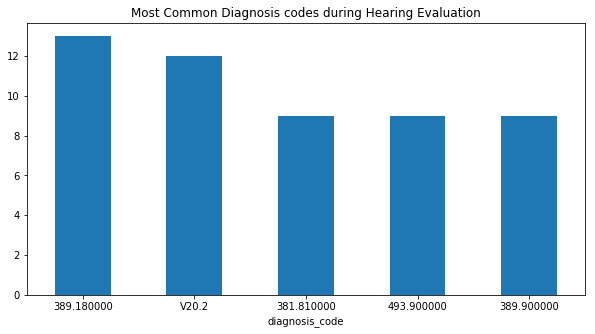

In [25]:
viz_2 = pandas_df_2_1.plot.bar(x= 'diagnosis_code',y= 'count',rot = 0, 
                 title = "Most Common Diagnosis codes during Hearing Evaluation",
                              figsize = (10,5),
                              legend = False)
viz_2

####  Step 3 :-  Saving the solution as .csv file

In [26]:
filename_2 = "/home/cloudera/Desktop/assignment/data_result_rdd/RDD_2.csv"
pandas_df_2_1.to_csv(filename_2, index = False, header = True)

###  Statement 3 :- The highest number of diagnoses assigned to a single patient. (RDD)

#### 3.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Extraction of patient_id from diagnoses_RDD.
* Step2:- Count no.of occurence of each patient_id using count_RDD
* Step3:- Sort in decreasing order of the keys

####  Step 1 :-  Extracting patient_id from the diagnoses RDD

In [27]:
patientID_RDD = diagnoses_RDD.map (lambda record: [record[i] for i in [0]])
patientID_RDD.take(5)  # Checking the output

# -------- < OUTPUT > ------------
# patientID_RDD = [(patient_id)]
# --------------------------------

[[u'00008RINR'],
 [u'00008RINR'],
 [u'00008RINR'],
 [u'00008RINR'],
 [u'00008RINR']]

####  Step 2 :-  Count patient_id using count_RDD using definition 1.1

In [28]:
patientID_countRDD = count_RDD(patientID_RDD)

####  Step 3 :-  Sorting the patient_id count in decreasing order

In [29]:
sort_patientID_Decr = patientID_countRDD.sortBy(lambda a: -a[1]) 
sort_patientID_Decr.take(5)

# -------- < OUTPUT > -----------------------------
# sort_patientID_Decr = [(patient_id), patient_id_count]
# -------------------------------------------------

[((u'59VKSHG5W',), 8557),
 ((u'S7ORRS7WB',), 7828),
 ((u'3SPYXMEMK',), 7592),
 ((u'T2FMCCLFU',), 6812),
 ((u'T9WIA97LK',), 6504)]

#### 3.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

####  Step 1 :-  Creating Dataframe pandas_df_3 using definition 1.2 

In [30]:
pandas_df_3 = spark_pandas(sort_patientID_Decr, 'patient_id','No.of Diagnoses')
pandas_df_3_1 = pandas_df_3.nlargest(5,'No.of Diagnoses')
pandas_df_3_1

,patient_id,No.of Diagnoses
0,"(59VKSHG5W,)",8557
1,"(S7ORRS7WB,)",7828
2,"(3SPYXMEMK,)",7592
3,"(T2FMCCLFU,)",6812
4,"(T9WIA97LK,)",6504


####  Step 2 :-  Plotting Bar Graph

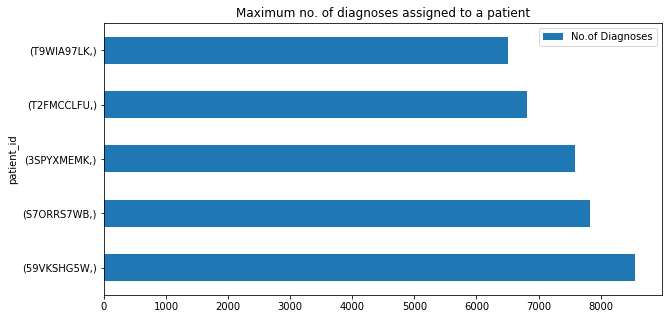

In [31]:
viz_3 = pandas_df_3_1.plot.barh(x= 'patient_id',y= 'No.of Diagnoses',rot = 0,
                                title = "Maximum no. of diagnoses assigned to a patient",
                                figsize = (10,5))
viz_3

####  Step 3 :-  Saving the solution as .csv file

In [32]:
filename_3 = "/home/cloudera/Desktop/assignment/data_result_rdd/RDD_3.csv"
pandas_df_3_1.to_csv(filename_3, index = False, header = True)

###  Statement 4 :- The client is interested in the total number of (different) people with a hearing problem in comparison to the total number of people who have had a hearing evaluation. (RDD)

#### 4.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Extraction patient_id and severity of hearing loss from hearing_evaluation_RDD.
* Step2:- Count no.of patient_id occured using def count_RDD from the RDD in (a)
* Step3:- Count no. of distict patients evaluated using .count() from RDD in (b)
* Step4:- Filter out 'Normal' and 'Insufficient Data' to obtain RDD with hearing problem
* Step5:- Calculate no. of distinct patients with hearing problems using (b) and (c)
* Step6:- Calculating percentage of patients with and without hearing problems

####  Step 1 :-  Extract required columns 

In [33]:
RDD4_1 = hearing_evaluation_RDD.map (lambda record: [record[i] for i in [0,2]])
RDD4_1.take(5)

#-------  < Output >  ----------------------------------
# RDD4_1 = [['patient_id','severity of hearing loss']]
# -----------------------------------------------------

[[u'000J1TN48', u'Normal'],
 [u'000JE5P7L', u'Normal'],
 [u'001M87HBZ', u'Normal'],
 [u'001M87HBZ', u'Mild'],
 [u'002ANH0GH', u'Normal']]

####  Step 2 :-  Calculating No. of patients that have been evaluated

In [34]:
RDD4_3 = count_RDD(RDD4_1.map (lambda record: [record[i] for i in [0]]))
Patients_evaluated_hearing = RDD4_3.count()
print 'No. of patients evaluated :-',Patients_evaluated_hearing

No. of patients evaluated :- 33892


####  Step 3 :-  Filtering RDD to obtain records for hearing problem 

In [35]:
RDD4_2 = RDD4_1.filter(lambda (a,b): b != 'Insufficient Data' and b != 'Normal')
RDD4_2.take(10)

[[u'001M87HBZ', u'Mild'],
 [u'00B0OT59S', u'Moderate'],
 [u'00HQAUUEY', u'Moderate'],
 [u'00JEZTXSZ', u'Mild'],
 [u'00K33OU94', u'Mild'],
 [u'00KPIFWS0', u'Slight'],
 [u'00NX57Z6O', u'Slight'],
 [u'00NX57Z6O', u'Mild'],
 [u'00ON22812', u'Mild'],
 [u'00RPIQR31', u'Slight']]

####  Step 4 :-  Calculating No. of distinct patients with hearing problems

In [36]:
RDD4_4 = count_RDD(RDD4_2.map (lambda record: [record[i] for i in [0]]))
Patients_hearing_problem = RDD4_4.count()
print 'No. of patients with hearing problem :-', Patients_hearing_problem

No. of patients with hearing problem :- 11417


####  Step 5 :-  Patients with normal hearing  

In [37]:
Patients_hearing_normal = int(Patients_evaluated_hearing) - int(Patients_hearing_problem)
print 'No. of patients without any problem :-',Patients_hearing_normal

No. of patients without any problem :- 22475


####  Step 6 :-  Calculation of percentage

In [38]:
# --> Percentage of Patients with hearing problem
Percentage_Patients_hearing_problem = round(float(Patients_hearing_problem)/
                                            float(Patients_evaluated_hearing)*100,2)
print'Patients with hearing problems (%) :-',Percentage_Patients_hearing_problem

# --> Percentage of Patients without hearing problem
Percentage_Patients_Normal = round(float(Patients_hearing_normal)/
                                   float(Patients_evaluated_hearing)*100,2)
print'Patients without hearing problems (%) :-',Percentage_Patients_Normal

Patients with hearing problems (%) :- 33.69
Patients without hearing problems (%) :- 66.31


#### 4.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

####  Step 1:- Creating pandas dataframe fromthe results found above

In [39]:
pandas_df_4_1 = pd.DataFrame({'Hearing Condition': ['With hearing problem','Without hearing problem'],
                    'Number of Patients':[Patients_hearing_problem,Patients_hearing_normal],
                      'Percentage of Patients':[Percentage_Patients_hearing_problem, 
                                            Percentage_Patients_Normal]})

pandas_df_4_1

,Hearing Condition,Number of Patients,Percentage of Patients
0,With hearing problem,11417,33.69
1,Without hearing problem,22475,66.31


#### Step 2 :- Visualisation using graphs

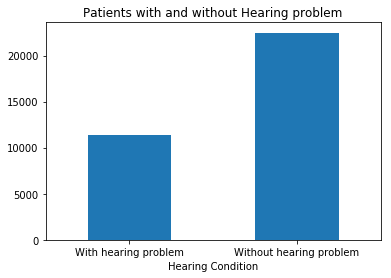

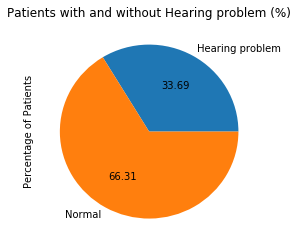

In [40]:
# --> a. Bar graph
viz_4_a = pandas_df_4_1.plot.bar(x= 'Hearing Condition',y= 'Number of Patients',rot = 0,
                title = 'Patients with and without Hearing problem',
                legend = False)



# --> b. Pie Chart 
viz_4_b = pandas_df_4_1.plot.pie(y= 'Percentage of Patients',
               labels = ['Hearing problem','Normal'],
                 autopct='%.2f',
               figsize=(4, 4),
                title = 'Patients with and without Hearing problem (%)',
                legend = False)

#### Step 4:-  Saving the solution as .csv file

In [41]:
filename_4 = "/home/cloudera/Desktop/assignment/data_result_rdd/RDD_4.csv"
pandas_df_4_1.to_csv(filename_4, index = False, header = True)

###  Statement 5 :- Average number of CT / MT / SC investigations performed on patients with hearing loss. (RDD)

#### 5.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Creating new imaging_RDD1 from imaging in such a way that [patient_id,(age, modality)] where 'patient_id' is key.
* Step2:- Inner Joining (by key) RDD from (a) and hearing_problem_RDD (Statement 4) 
* Step3:- Calculate total number of investiagations from join RDD.
* Step4:- Calculate Number of patients from join RDD.
* Step5:- Calculate avergae number of investigation per patient
* Step6:- Investigation percentage

#### Step 1 :- Creating new RDD from imaging

In [42]:
imaging_RDD1 = imaging_RDD.map(lambda fields: (fields[0],(fields[1],fields[2])))
imaging_RDD1.take(5) 

#-------  < Output 5.a >  ----------------------------------
# imaging_RDD1 = ['patient_id',('imaging_age', 'modality)]
# ----------------------------------------------------------

[(u'00R99YUB4', (u'8.15341238568207', u'CT')),
 (u'0263DNQG8', (u'0.078671260881339', u'CT')),
 (u'02AQQ4CLC', (u'5.47329158513104', u'MR')),
 (u'02AQQ4CLC', (u'5.58251725238167', u'MR')),
 (u'02AQQ4CLC', (u'5.72791714662045', u'MR'))]

#### Step 2: Creating Inner join

In [43]:
hearing_imaging_joinRDD = RDD4_2.join(imaging_RDD1).map(lambda fields: 
                                                        (fields[0],
                                                         fields[1][1][0],
                                                         fields[1][1][1]))
hearing_imaging_joinRDD.take(2)     # --> patientid,modality

#-------  < Output 5.b >  ----------------------------------
# joinRDD = [('17HHKTNKT', ('Moderate', ('5.29806539227812', 'CT')))
# hearing_imaging_joinRDD = ['patient_id','age','modality']
# ----------------------------------------------------------

[(u'N3QKPK7TH', u'0.260101380016059', u'CT'),
 (u'ORDWBUHBJ', u'6.14926446989035', u'CT')]

#### Step 3:-  Calculation No. of investigations
* Total number of investigations done on patients with hearing loss
* CT_ count 
* MR_count
* SC_count

In [44]:
# --------------------
# Total investigation
# --------------------
total_investigations = hearing_imaging_joinRDD.count()
print 'Total investigations:', total_investigations

# -------------
#   CT_count
# -------------
# --> Retaining CT only from joined RDD
CT_RDD = hearing_imaging_joinRDD.filter(lambda fields: fields[2] == 'CT')
#CT_RDD.take(2)

# --> Counting Number of CT
CT_count = CT_RDD.count()
print 'No. of CTs to patients with hearing problem :-',CT_count

# -------------
#   MR_count
# -------------
# --> Retaining MR only from joined RDD
MR_RDD = hearing_imaging_joinRDD.filter(lambda fields: fields[2] == 'MR')
#MR_RDD.take(2)

# --> Counting Number of MR
MR_count = MR_RDD.count()
print 'No. of MRs to patients with hearing problem :-',MR_count

# -----------
#   SC_count
# -----------
# --> Retaining SC only from joined RDD
SC_RDD = hearing_imaging_joinRDD.filter(lambda fields: fields[2] == 'SC')
#SC_RDD.take(2)

# --> Counting Number of SC
SC_count = SC_RDD.count()
print 'No. of SCs to patients with hearing problem :-',SC_count

Total investigations: 1418
No. of CTs to patients with hearing problem :- 813
No. of MRs to patients with hearing problem :- 602
No. of SCs to patients with hearing problem :- 3


#### Step 4 :- Calculating Number of patients

In [45]:
RDD5_3 = hearing_imaging_joinRDD.map (lambda record: [record[i] for i in [0]])
Patients_count = count_RDD(RDD5_3).count()
print 'Number of patients',Patients_count

Number of patients 460


#### Step 5 :-  Calculation of Average Investigation per patient
* Average CT per patient
* Average MR per patient
* Average SC per patient

In [46]:
# --> i Average CT per patient 
CT_per_patient = round(float(CT_count)/float(Patients_count),3)
print'Average CT per patient :-', CT_per_patient

# --> ii Average MR per patient
MR_per_patient = round(float(MR_count)/float(Patients_count),3)
print 'Average MR per patient :-', MR_per_patient

# --> iii Average SC per patient 
SC_per_patient = round(float(SC_count)/float(Patients_count),3)
print 'Average SC per patient :-',SC_per_patient

Average CT per patient :- 1.767
Average MR per patient :- 1.309
Average SC per patient :- 0.007


#### Step 6 :- Investiagtion Percentage
* Percentage of CT of total investigation
* Percentage of MR of total investigation
* Percentage of SC of total investigation

In [47]:
# --> i. CT percentage
CT_percentage = round(float(CT_count)/ float(total_investigations)*100,2)
print 'Percentage of CT :-',CT_percentage

# --> ii. MR percentage
MR_percentage = round(float(MR_count)/float(total_investigations)*100,2)
print 'Percentage of MR :-',MR_percentage

# --> iii. SC percentage
SC_percentage = round(float(SC_count)/ float(total_investigations)*100,2)
print 'Percentage of SC :-',SC_percentage

Percentage of CT :- 57.33
Percentage of MR :- 42.45
Percentage of SC :- 0.21


#### 5.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1 :-  Creating Pandas Dataframe

In [48]:
pandas_df_5_1 =  pd.DataFrame({'Evaluation':['CT','MR','SC'],
                    'Count':[CT_count,MR_count,SC_count],
                      'Average_per_patient': [CT_per_patient,
                                                   MR_per_patient,
                                                   SC_per_patient],
                      'Percentage':[CT_percentage, MR_percentage, SC_percentage]})
pandas_df_5_1

,Average_per_patient,Count,Evaluation,Percentage
0,1.767,813,CT,57.33
1,1.309,602,MR,42.45
2,0.007,3,SC,0.21


#### Step 2:- Visualisation using plots
* Bar chart 
* Pie Chart

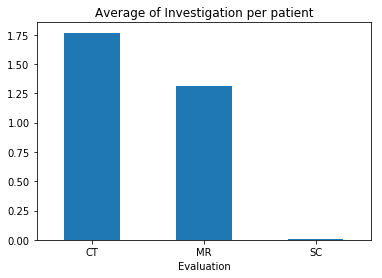

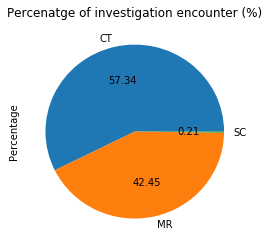

In [49]:
# --> b Ploting Bar chart
pandas_df_5_1.plot.bar(x= 'Evaluation',y= 'Average_per_patient',rot = 0, 
               legend = False,
                title = 'Average of Investigation per patient'
                )


# --> c Ploting pie chart
pandas_df_5_1.plot.pie(y= 'Percentage', figsize=(4,4),
               autopct='%.2f', legend = False,
               labels = ['CT','MR','SC'],
                title = 'Percenatge of investigation encounter (%)')

#### Step 3:- Saving the solution as .csv file 

In [50]:
filename_5 = "/home/cloudera/Desktop/assignment/data_result_rdd/RDD_5.csv"
pandas_df_5_1.to_csv(filename_5, index = False, header = True)

###  Statement 6 :- The client would like to know the year group (i.e. you will need to group the ages of encounter into years) which is given the greatest number of CTs. (RDD)

#### 6.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Change imaging RDD, string age -> float age -> int age.
* Step2:- Filtering RDD (from a) including CT only 
* Step3:- Extracting age from filtered RDD (c).
* Step4:- Counting number of times each year_group occured using def count_RDD.This implies no. of times CT occured in each year group 

In [51]:
from pyspark.sql import functions as F

#### Step 1 :-  Converting age from string -> float -> integer (age -> year_group)

In [52]:
RDD6_1 = imaging_RDD.map(lambda (patient_id, age, modality): (patient_id,float(age),modality))
RDD6_2 = RDD6_1.map(lambda (patient_id, age, modality): (patient_id,int(age),modality))
RDD6_2.take(5)
# ----------   | ERROR |   -----------------------------------------------
# ERROR (When age was directly converted from string to int)
# ValueError: invalid literal for int() with base 10: '8.15341238568207'
# -----------------------------------------------------------------------

[(u'00R99YUB4', 8, u'CT'),
 (u'0263DNQG8', 0, u'CT'),
 (u'02AQQ4CLC', 5, u'MR'),
 (u'02AQQ4CLC', 5, u'MR'),
 (u'02AQQ4CLC', 5, u'MR')]

#### Step 2 :- Filtering - including modality = CT

In [53]:
RDD6_3 = RDD6_2.filter(lambda(patient_id, age, modality): modality == 'CT')
RDD6_3.take(5)

[(u'00R99YUB4', 8, u'CT'),
 (u'0263DNQG8', 0, u'CT'),
 (u'03L1A3ZBB', 2, u'CT'),
 (u'04T2TBJU0', 8, u'CT'),
 (u'05S8KKZXZ', 2, u'CT')]

#### Step 3 :- Extracting age from filtered RDD 6_3 (where modality = CT)

In [54]:
age_RDD6_4 = RDD6_3.map(lambda record: [record[i] for i in [1]])
age_RDD6_4.take(6)

#-------  < Output 6.c >  ------
# age_RDD6_4 = [imaging_age]
# ------------------------------

[[8], [0], [2], [8], [2], [1]]

#### Step 4 :- Counting number of times each year_group occured using def count_RDD. This implies no. of times CT occured in each year group  

In [55]:
RDD6_5 = count_RDD(age_RDD6_4).sortByKey(lambda a: -a[1])
RDD6_6 = RDD6_5.map(lambda((a),b) : [a,b])
RDD6_6.take(5)

[[(0,), 160], [(1,), 94], [(2,), 213], [(3,), 210], [(4,), 81]]

#### 6.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe (line graph)
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1 :- Creating Pandas Dataframe

In [56]:
pandas_df_6 = spark_pandas(RDD6_5, 'Year_group','count')
pandas_df_6

,Year_group,count
0,"(0,)",160
1,"(1,)",94
2,"(2,)",213
3,"(3,)",210
4,"(4,)",81
5,"(5,)",202
6,"(6,)",66
7,"(7,)",115
8,"(8,)",119
9,"(9,)",95


#### Step 2 :-  Plot line chart

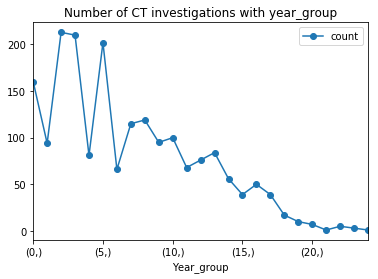

In [57]:
viz_RDD_6 = pandas_df_6.plot(
    x='Year_group', linestyle='-', marker='o',
    figsize = (6,4),
    title = 'Number of CT investigations with year_group')
viz_RDD_6

#### Step 3 :- Saving the solution as .csv file

In [58]:
filename_6 = "/home/cloudera/Desktop/assignment/data_result_rdd/RDD_6.csv"
pandas_df_6.to_csv(filename_6, index = False, header = True)

###  Statement 7 :- For each year group, the client would like to visualize the most frequent diagnosis code (with its frequency). (RDD)

#### 7.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Convert the age from decimal to int.
* Step2:- Finding diagnosis_code count for each diagnosis_code and year_age ( df_a) 
* Step3:- Finding maximum code count for each year group (df_b).
* Step4:- Inner join (df_a) and (df_b) where code_count = max_code_count & year_group = year_group
--> [Year_group, diagnosis_code, mx_count]

#### Step 1 :-  Convering diagnosis_age to float and to string

In [59]:
RDD7_1 = diagnoses_RDD.map(lambda (patient_id, diagnosis_code, diagnosis_age): 
                           (patient_id,diagnosis_code,float(diagnosis_age)))

RDD7_2 = RDD7_1.map(lambda (patient_id, diagnosis_code, diagnosis_age): 
                    (patient_id, diagnosis_code, int(diagnosis_age)))
RDD7_2.take(5)

[(u'00008RINR', u'315.320000', 2),
 (u'00008RINR', u'315.320000', 2),
 (u'00008RINR', u'315.320000', 2),
 (u'00008RINR', u'315.320000', 5),
 (u'00008RINR', u'315.320000', 5)]

#### Step 2 :- Creating a new RDD [year_group, diagnosis_code]

In [60]:
RDD7_3 = RDD7_2.map(lambda record: [record[i] for i in [2,1]])
RDD7_3.take(5)
#-------  < Output 7.b >  -------------
# RDD7_3= [year_group, diagnosis_code]
# -------------------------------------

[[2, u'315.320000'],
 [2, u'315.320000'],
 [2, u'315.320000'],
 [5, u'315.320000'],
 [5, u'315.320000']]

#### Step 3 :-  Counting RDD using count_RDD [year_group, diagnosis_code]

In [61]:
RDD7_4 = count_RDD(RDD7_3).map(lambda ((year_group,diagnosis_code)
                                       ,frequency):
                               (year_group,diagnosis_code,frequency))
RDD7_4.take(5)   

#-------  < Output 7.c >  -------------------------
# RDD7_4 = [year_group, diagnosis_code, frequency]
# -------------------------------------------------

[(3, u'259.900000', 59),
 (16, u'325.000000', 23),
 (5, u'T45.1X5D', 26),
 (9, u'398.900000', 13),
 (2, u'531.700000', 2)]

####   Step 4:-  Extracting [year_group, frequency] from RDD7_4

In [62]:
RDD7_5 = RDD7_4.map(lambda (a,b,c): (a,c))
RDD7_5.take(5)

[(3, 59), (16, 23), (5, 26), (9, 13), (2, 2)]

####  Step 5 :- Getting maximum frequency per year group

In [63]:
RDD7_6 = RDD7_5.reduceByKey(max).map(lambda (k,v):((k,v),1))
RDD7_6.take(5)
#-------  < Output 7.e >  -------------------------
# RDD7_6 = [((year_group,max_frequency),1)]
# making year_group and max_frequency as keys
# -------------------------------------------------

[((0, 148071), 1), ((70, 8), 1), ((42, 33), 1), ((14, 4170), 1), ((84, 10), 1)]

#### Step 6 :-   Extracting from RDD7_4 [(year_group,frequency), diagnosis_code]

In [64]:
RDD7_7 = RDD7_4.map(lambda fields: ((fields[0], fields[2]),fields[1]))
RDD7_7.take(5)

[((3, 59), u'259.900000'),
 ((16, 23), u'325.000000'),
 ((5, 26), u'T45.1X5D'),
 ((9, 13), u'398.900000'),
 ((2, 2), u'531.700000')]

#### Step 7 :-  Inner join RDD7_7 and RDD7_6

In [65]:
Year_group_code_RDD = RDD7_7.join(RDD7_6).map(lambda ((k1,v1),(k2,v2)): 
                                              ((k1,k2,v1))).filter(lambda fields: 
                                                                   fields[0] >= 0)
Year_group_code_RDD.take(5)

#-------  < Output 7.g >  ---------------------------------------
# Year_group_code_RDD  = (year_group, diagnosis_code,frequency)
# --------------------------------------------------------------

[(40, u'282.490000', 42),
 (84, u'389.100000', 10),
 (84, u'381.700000', 10),
 (48, u'277.020000', 30),
 (20, u'389.180000', 646)]

#### 7.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file
* Step 4:-Plotting the bar graphs using multiple age range 

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Definition 7.1 
Creating pandas dataframes from RDD with 3 columns

In [67]:
# ------------ Definition 7.1 ----------------
def spark_pandas_1(RDD,a,b,c):
    DF_spark = RDD.toDF()
    DF_pandas = DF_spark.toPandas()
    DF_pandas_rename_1 = DF_pandas.rename(
        columns={"_1": a, "_2": b, "_3":c})
    return DF_pandas_rename_1
# --------------------------------------------

#### Step 1 :- Creating pandas dataframe using definition 7.1

In [68]:
pandas_df_7 = spark_pandas_1(Year_group_code_RDD, 'Year_group','diagnosis_code','code_count')

pandas_df_7

,Year_group,diagnosis_code,code_count
0,40,282.490000,42
1,84,389.100000,10
2,84,381.700000,10
3,48,277.020000,30
4,20,389.180000,646
5,85,H69.00,6
6,85,381.700000,6
7,57,H69.93,2
8,57,724.400000,2
9,57,381.810000,2


#### Step 2 :-  Visualisation using the whole data

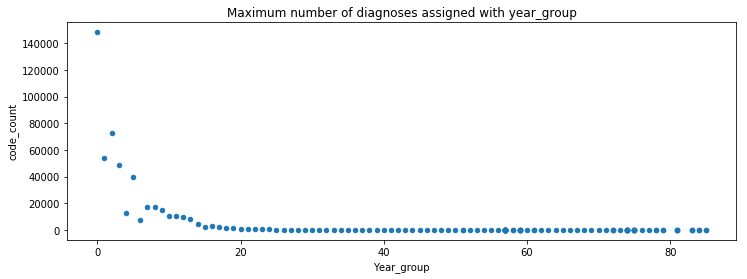

In [69]:
viz_7_1 = pandas_df_7.plot.scatter (x = 'Year_group',
                           y = 'code_count',
                             figsize=(12,4),
                             title = 'Maximum number of diagnoses assigned with year_group')
viz_7_1

#### Step 3 :- Saving the solution as .csv file

In [70]:
filename_7 = "/home/cloudera/Desktop/assignment/data_result_rdd/RDD_7.csv"
pandas_df_7.to_csv(filename_7, index = False, header = True)

##### Definition 7.2 
Creating multiple pandas dataframe based on age range for visualisation

In [71]:
# ------------- Definition 7.2 --------------------------
def age_filter_1(pandas_df,age) :
    bol_age_df = pandas_df['Year_group'] >= age
    age_df = pandas_df[bol_age_df]
    return (age_df)

def age_filter_2(pandas_df,age1,age2):
    bol_age1_df = pandas_df['Year_group'] >= age1
    bol_age2_df = pandas_df['Year_group'] <= age2
    age_df = pandas_df[bol_age1_df & bol_age2_df ]
    return age_df

def age_filter_3(pandas_df,age) :
    bol_age_df = pandas_df['Year_group'] <= age
    age_df = pandas_df[bol_age_df]
    return (age_df)

#### Step 4 :- Creating multiple dataframes based on age range using definition 7.2

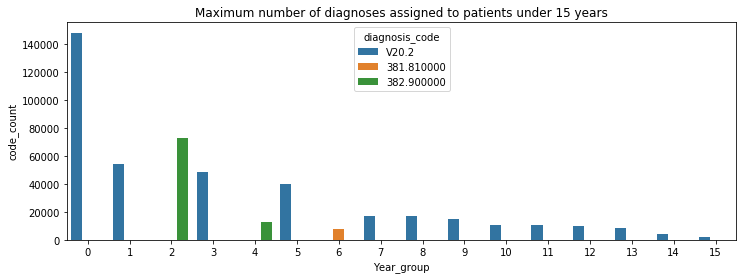

In [72]:
# --> a.ii Under 15 years
under15years = age_filter_2(pandas_df_7,0,15)

# --> Plot graph
plt.figure(figsize=(12, 4))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=under15years
           ).set_title("Maximum number of diagnoses assigned to patients under 15 years");

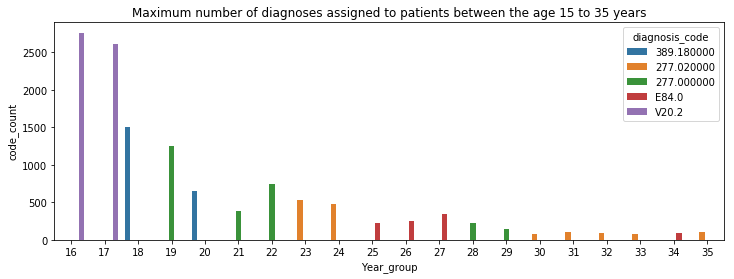

In [73]:
# --> a.iii 15 to 35 years
Age15to35 = age_filter_2(pandas_df_7,16,35)

plt.figure(figsize=(12, 4))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age15to35
           ).set_title("Maximum number of diagnoses assigned to patients between the age 15 to 35 years");

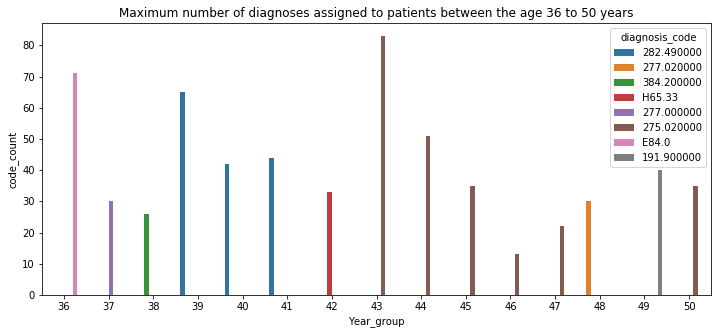

In [74]:
# --> a.iv 36 to 50 years
Age36to50 = age_filter_2(pandas_df_7,36,50)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age36to50
           ).set_title("Maximum number of diagnoses assigned to patients between the age 36 to 50 years");


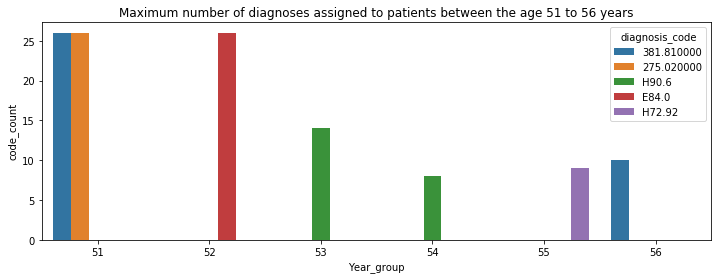

In [75]:
# --> a.v 51 to 56 years
Age51to56 = age_filter_2(pandas_df_7,51,56)
#print(DF7_7_Age25to34)

plt.figure(figsize=(12, 4))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age51to56
           ).set_title("Maximum number of diagnoses assigned to patients between the age 51 to 56 years");

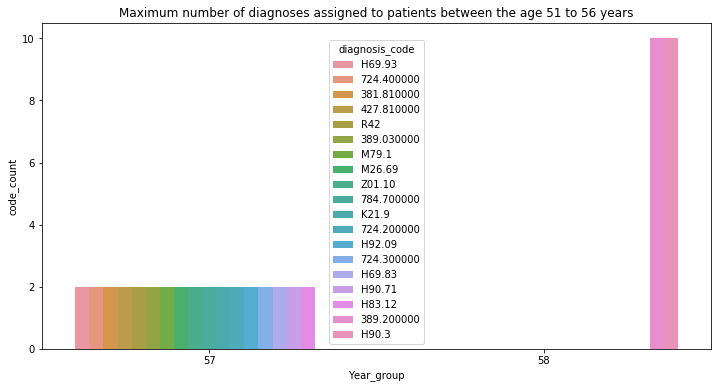

In [76]:
# --> a.v 57 to 58 years
Age57to58 = age_filter_2(pandas_df_7,57,58)
#print(DF7_7_Age25to34)

plt.figure(figsize=(12, 6))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age57to58
           ).set_title("Maximum number of diagnoses assigned to patients between the age 51 to 56 years");

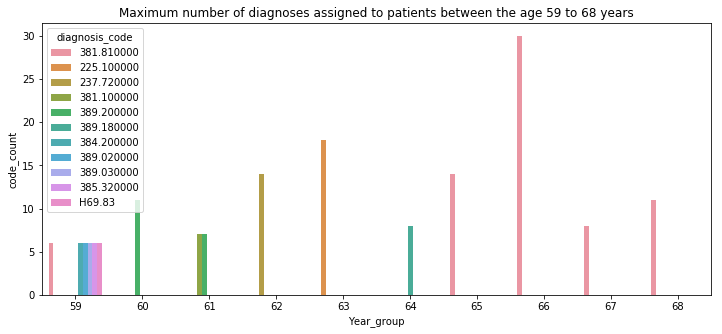

In [77]:
# --> a.vii 59 to 68 years
Age59to68 = age_filter_2(pandas_df_7,59,68)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age59to68
           ).set_title("Maximum number of diagnoses assigned to patients between the age 59 to 68 years");


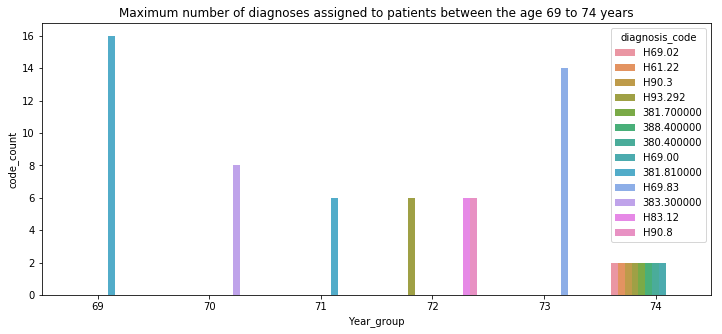

In [78]:
# --> a.vii 69 to 74 years
Age69to74 = age_filter_2(pandas_df_7,69,74)
#print(DF7_7_Age69to74)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age69to74
           ).set_title("Maximum number of diagnoses assigned to patients between the age 69 to 74 years");


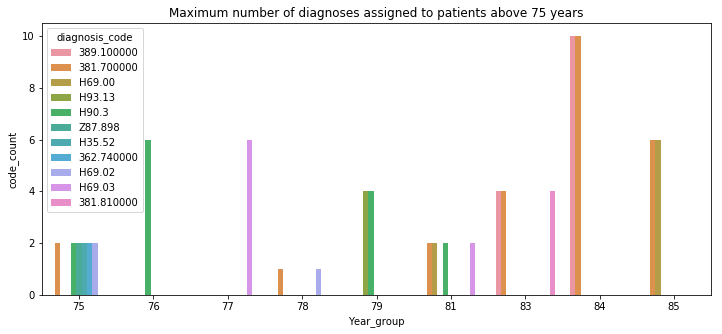

In [79]:
# --> a.ix Above 75 years
Above75years = age_filter_1(pandas_df_7,75)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Above75years
           ).set_title("Maximum number of diagnoses assigned to patients above 75 years");# --> a.ix Above 75 years


##### ------------------------------------
## 5. Dataframes (DF)
##### ------------------------------------

In [7]:
# ============================================
#               INITIALISATION 
# ============================================

# -------> |Creating paths for .csv file| <------

# a. path for hearing evaluation csv file
path_hearing_evaluation = "file:/home/cloudera/Desktop/assignment/hearing_evaluation.csv"

# b. path for imaging csv file
path_imaging = "file:/home/cloudera/Desktop/assignment/imaging.csv"

# c. path for diagnoses csv file
path_diagnoses = "file:/home/cloudera/Desktop/assignment/diagnoses.csv"


# ---------> |Uploading .csv files as dataframes | <--------

# a. hdfs safe mode off
! hdfs dfsadmin -safemode leave   

# b. imaging dataframe
imaging_df = diagnoses_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true',inferschema='true').load(path_imaging)

# c. hearing evaluation dataframe
hearing_evaluation_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true',inferschema='true').load(path_hearing_evaluation)

# d. Diagnosis dataframe
diagnoses_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true',inferschema='true').load(path_diagnoses)

Safe mode is OFF


Creating necessary directories to save all the output as .csv files in the created directory

In [8]:
if not os.path.exists('/home/cloudera/Desktop/assignment/data_result_df'):
    os.system('mkdir /home/cloudera/Desktop/assignment/data_result_df')
    print 'The Directory has been created'

Checking if the dataframes are correctly loaded

In [9]:
from pyspark.sql import DataFrame
assert isinstance(imaging_df, DataFrame), "Your answer should be a dataframe"
assert isinstance(hearing_evaluation_df, DataFrame), "Your answer should be a dataframe"
assert isinstance(diagnoses_df, DataFrame), "Your answer should be a dataframe"

Checking the imported dataframes

In [10]:
hearing_evaluation_df.show(5)
imaging_df.show(2)
diagnoses_df.show(2)

+----------+----------------+------------------------+-----------------------+---------------------------+------------------------------+
|patient_id|  evaluation_age|severity_of_hearing_loss|unilateral_or_bilateral|has_conductive_hearing_loss|has_sensorineural_hearing_loss|
+----------+----------------+------------------------+-----------------------+---------------------------+------------------------------+
| 000J1TN48|2.11859389559818|                  Normal|      Insufficient Data|                          f|                             f|
| 000JE5P7L|3.38154832047061|                  Normal|      Insufficient Data|                          f|                             f|
| 001M87HBZ|5.19128693100837|                  Normal|      Insufficient Data|                          t|                             f|
| 001M87HBZ|8.24376339137186|                    Mild|      Insufficient Data|                          t|                             f|
| 002ANH0GH|7.35543953897321|     

In [11]:
# Importing libraries for visualisation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

----------------------------------------------------------------------
### Statement 1 :-  The 5 most common diagnosis codes along with their frequencies (DF)
#### 1.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Count diagnosis code, group by diagnosis code,sort in decreasing order

In [12]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
from pyspark.sql.functions import col

#### Step 1 :- Count diagnosis code, group by diagnosis code,sort in decreasing order.

In [13]:
df1_1 = diagnoses_df.groupby('diagnosis_code').count().sort(col("count").desc()) 
print ('The 5 most common diagnosis codes')  
df1_1.show(5)                        
#-----| Output |-----------------
# df1_1 = diagnosis_code, count
# -------------------------------

The 5 most common diagnosis codes
+--------------+------+
|diagnosis_code| count|
+--------------+------+
|         V20.2|476228|
|    382.900000|272497|
|    389.900000|256345|
|    381.810000|213910|
|    465.900000|175831|
+--------------+------+
only showing top 5 rows



#### 1.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1 :-  Converting spark dataframe to pandas dataframe and extracting 5 largest count

In [14]:
pd_df_1 = df1_1.toPandas().nlargest(5,'count')  # Extract 5 largest by 'count'
pd_df_1           

,diagnosis_code,count
0,V20.2,476228
1,382.900000,272497
2,389.900000,256345
3,381.810000,213910
4,465.900000,175831


#### Step 2 :- Plotting graphs (Bar plot)

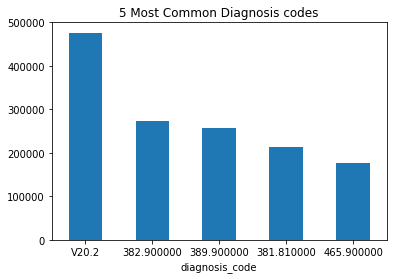

In [15]:
viz_DF_1 = pd_df_1.plot.bar(x= 'diagnosis_code',y= 'count',rot = 0, 
                            title = "5 Most Common Diagnosis codes",
                           legend = False)
viz_DF_1

#### Step 3 :-  Saving the solution as .csv file

In [ ]:
filename_1 = "/home/cloudera/Desktop/assignment/data_result_df/DF_1.csv"
pd_df_1.to_csv(filename_1, index = False, header = True)

--------------------------------------------------
###  Statement 2 :- Top 5 most common diagnosis codes given to patients at the time of hearing evaluation with their frequencies. (DF)

#### 2.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Inner join 'diagnosis' and 'hearing evaluation' 
Condition :- age and patient_id.
* Step2:- Count diagnosis_code, group by 'diagnosis_code' and sort in decreasing order

#### Step 1 :- Inner join 'diagnosis' and 'hearing evaluation' 

In [16]:
df2_1  = diagnoses_df.join(hearing_evaluation_df, [(diagnoses_df.diagnosis_age == hearing_evaluation_df.evaluation_age) & (diagnoses_df.patient_id == hearing_evaluation_df.patient_id)], how = "inner")
df2_1.show(5)

+----------+--------------+----------------+----------+----------------+------------------------+-----------------------+---------------------------+------------------------------+
|patient_id|diagnosis_code|   diagnosis_age|patient_id|  evaluation_age|severity_of_hearing_loss|unilateral_or_bilateral|has_conductive_hearing_loss|has_sensorineural_hearing_loss|
+----------+--------------+----------------+----------+----------------+------------------------+-----------------------+---------------------------+------------------------------+
| PPLIKTJ46|    389.100000|4.08640492198418| PPLIKTJ46|4.08640492198418|                  Normal|                 Normal|                          f|                             f|
| PPLIKTJ46|    389.150000|4.08640492198418| PPLIKTJ46|4.08640492198418|                  Normal|                 Normal|                          f|                             f|
| PPLIKTJ46|    474.100000|4.08640492198418| PPLIKTJ46|4.08640492198418|                  Norma

#### Step 2 :- Dataframe with diagnosis_code and frequency, sorted in decreasing order

In [17]:
df2_2 = df2_1.groupby('diagnosis_code').count().sort(col("count").desc())
#df2_2.show(5)

#-----| Output |-----------------
# df2_1 = diagnosis_code, count
# -------------------------------

#### 2.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1 :- Creating pandas dataframe

In [18]:
pd_df_2 = df2_2.toPandas().nlargest(5,'count')
pd_df_2

,diagnosis_code,count
0,389.180000,13
1,V20.2,12
2,493.900000,9
3,315.390000,9
4,389.900000,9


#### Step 2 :- Plot (bar plot)

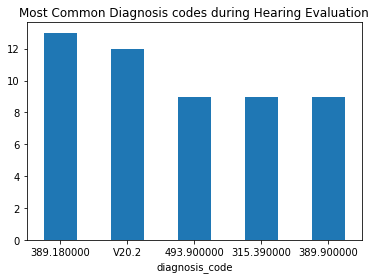

In [19]:
viz_DF_2 = pd_df_2.plot.bar(x= 'diagnosis_code',y= 'count',rot = 0, 
                 title = "Most Common Diagnosis codes during Hearing Evaluation",
                           legend = False)

viz_DF_2

#### Steo 3 :- Saving the solution as .csv file

In [ ]:
filename_2 = "/home/cloudera/Desktop/assignment/data_result_df/DF_2.csv"
pd_df_2.to_csv(filename_2, index = False, header = True)

###  Statement 3 :- The highest number of diagnoses assigned to a single patient (DF)

#### 3.1 DATA ANALYSIS
Approach adapted:-
* Count patient_id, group by patient_id,sort in decreasing order.

In [20]:
df3_1 = diagnoses_df.groupby('patient_id').count().sort(col("count").desc())
df3_1.show(5)

#-----| Output |-----------------
# df3_1 = patient_id, count
# -------------------------------

+----------+-----+
|patient_id|count|
+----------+-----+
| 59VKSHG5W| 8557|
| S7ORRS7WB| 7828|
| 3SPYXMEMK| 7592|
| T2FMCCLFU| 6812|
| T9WIA97LK| 6504|
+----------+-----+
only showing top 5 rows



#### 3.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1:-  Changing into pandas and Renaming the column to 'No of Diagnoses'

In [21]:
pd_df_3 = df3_1.toPandas().nlargest(5,'count').rename(columns = {"count": "No.of Diagnoses"})
pd_df_3 

,patient_id,No.of Diagnoses
0,59VKSHG5W,8557
1,S7ORRS7WB,7828
2,3SPYXMEMK,7592
3,T2FMCCLFU,6812
4,T9WIA97LK,6504


#### Step 2 :-  Plotting bar plot

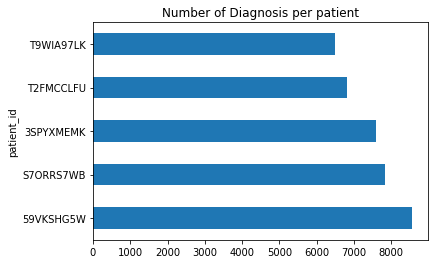

In [22]:
viz_DF_3 = pd_df_3.plot.barh(x= 'patient_id',y= 'No.of Diagnoses',rot = 0,
                            title = 'Number of Diagnosis per patient',
                            legend = False)
viz_DF_3

#### Step 3 :-  Saving the solution as .csv file

In [23]:
filename_3 = "/home/cloudera/Desktop/assignment/data_result_df/DF_3.csv"
pd_df_3.to_csv(filename_3, index = False, header = True)

###  Statement 4 :- The client is interested in the total number of (different) people with a hearing problem in comparison to the total number of people who have had a hearing evaluation. (DF)

#### 4.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Filtering where severity_of_hearing is not 'normal' and not 'insufficient data'.
* Step2:- Calculate No.of patients : i)evaluated (hearing_evaluation_df),ii) with hearing problem (hearing_problem_df)),iii) without hearing problem.
* Step3:- Calculate percentage of patients with hearing_problem and without hearing problem

#### Step 1:-  Filtering to obtain Dataframe account for patients with hearing problems.

In [24]:
hearing_problem_df = hearing_evaluation_df.select('patient_id','severity_of_hearing_loss').where('severity_of_hearing_loss != "Normal" and severity_of_hearing_loss != "Insufficient Data"')
hearing_problem_df.show(5)

+----------+------------------------+
|patient_id|severity_of_hearing_loss|
+----------+------------------------+
| 001M87HBZ|                    Mild|
| 00B0OT59S|                Moderate|
| 00HQAUUEY|                Moderate|
| 00JEZTXSZ|                    Mild|
| 00K33OU94|                    Mild|
+----------+------------------------+
only showing top 5 rows



#### Step 2 :-  Calculation of the Number of patients
* patients evaluated
* patients with hearing problems 
* patients without hearing problems (Normal)

In [25]:
# --> Patients_evaluated 
Patients_evaluated_hearing = hearing_evaluation_df.select('patient_id').distinct().count()
print 'No. of patients evaluated :-',Patients_evaluated_hearing

# --> Patients_hearing_problem 
patient_hearing_problem_df = hearing_problem_df.select('patient_id').distinct()
Patients_hearing_problem = patient_hearing_problem_df.count()
print 'No. of patients with hearing problem :-', Patients_hearing_problem

# --> Patients without problem (Normal)
Patients_hearing_normal = Patients_evaluated_hearing - Patients_hearing_problem
print 'No. of patients without any problem :-',Patients_hearing_normal

No. of patients evaluated :- 33892
No. of patients with hearing problem :- 11417
No. of patients without any problem :- 22475


#### Step 3:- Calculation of percentage 
* percentage of patients with hearing problems 
* percentage of patients withouthearing problems

In [26]:
# --> Percentage of Patients with hearing problem
Percentage_Patients_hearing_problem = round(float(Patients_hearing_problem)/
                                            float(Patients_evaluated_hearing)*100,2)
print'Patients with hearing problems (%) :-',Percentage_Patients_hearing_problem

# --> Percentage of Patients without hearing problem
Percentage_Patients_Normal = round(float(Patients_hearing_normal)/
                                   float(Patients_evaluated_hearing)*100,2)
print'Patients without hearing problems (%) :-',Percentage_Patients_Normal

Patients with hearing problems (%) :- 33.69
Patients without hearing problems (%) :- 66.31


#### 4.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1:- Creating pandas dataframe from the results found above

In [27]:
pd_df_4 = pd.DataFrame({'Hearing Condition': ['With hearing problem','Without hearing problem'],
                    'Number of Patients':[Patients_hearing_problem,Patients_hearing_normal],
                      'Percentage of Patients':[Percentage_Patients_hearing_problem, 
                                            Percentage_Patients_Normal]})

pd_df_4

,Hearing Condition,Number of Patients,Percentage of Patients
0,With hearing problem,11417,33.69
1,Without hearing problem,22475,66.31


#### Step 2:- Visualisation using plots (Bar and pie)

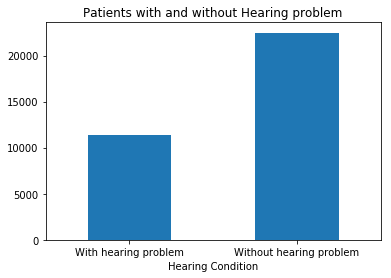

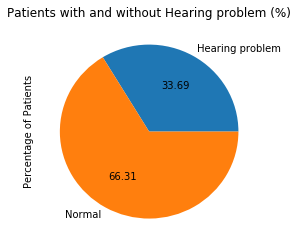

In [28]:
# --> b. Bar graph
viz_df_4_a = pd_df_4.plot.bar(x= 'Hearing Condition',y= 'Number of Patients',rot = 0,
                title = 'Patients with and without Hearing problem',
                legend = False)
                             

# --> c. Pie Chart 
viz_df_4_b = pd_df_4.plot.pie(y= 'Percentage of Patients',
               labels = ['Hearing problem','Normal'],
                 autopct='%.2f',
               figsize=(4, 4),
                title = 'Patients with and without Hearing problem (%)',
                legend = False)

#### Step 3 :- Saving the solution as .csv file

In [ ]:
filename_4 = "/home/cloudera/Desktop/assignment/data_result_df/DF_4.csv"
pd_df_4.to_csv(filename_4, index = False, header = True)

###  Statement 5 :- Average number of CT / MT / SC investigations performed on patients with hearing loss. (DF)

#### 5.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Inner join, condition on patient_id (hearing_evaluation and imaging).
* Step2:- Number of investigation (CT, MR, SC) and Number of patients evaluated
* Step3:- Investigation per patients
* Step4:- Percentage investigation

#### Step 1:-  Creating hearing and imaging join on patient_id 

In [29]:
hearing_imaging_df = hearing_problem_df.join(imaging_df,
                                             [(hearing_problem_df.patient_id == imaging_df.patient_id)],
                                             how = "inner").select(hearing_problem_df.patient_id, 
                                                                   imaging_df.imaging_age,imaging_df.modality)
hearing_imaging_df.show(5)

#---------- | Output | ----------------------------------
# hearing_imaging_df = patient_id, imaging_age, modality
# ......................................................

+----------+----------------+--------+
|patient_id|     imaging_age|modality|
+----------+----------------+--------+
| 2PH8S1G0E|2.18704162718136|      CT|
| 2PH8S1G0E|2.23442687701587|      CT|
| 2PH8S1G0E|2.35489488460225|      CT|
| 2PH8S1G0E|2.96538611244491|      CT|
| 2PH8S1G0E|3.43083068721049|      CT|
+----------+----------------+--------+
only showing top 5 rows



#### Step 2:-  Calculation No. of investigation, CT/MR/SC , patients 

In [30]:
# --> i. CT count
CT_count = hearing_imaging_df.select('patient_id','modality').where('modality = "CT"').count()
print 'No. of CTs to patients with hearing problem :-',CT_count

# --> ii MR count
MR_count = hearing_imaging_df.select('patient_id','modality').where('modality = "MR"').count()
print 'No. of MRs to patients with hearing problem :-', MR_count

# --> iii SC count
SC_count = hearing_imaging_df.select('patient_id','modality').where('modality = "SC"').count()
print 'No. of SCs to patients with hearing problem :-',SC_count

# --> i.v Number of investigation 
Investigation_count = hearing_imaging_df.select('patient_id','modality').count()
print 'No. of investigations :-', Investigation_count

# --> v Number of patients 
Patients_count = hearing_imaging_df.select('patient_id').distinct().count()
print 'Number of patients evaluated with hearing problem :-',Patients_count

No. of CTs to patients with hearing problem :- 813
No. of MRs to patients with hearing problem :- 602
No. of SCs to patients with hearing problem :- 3
No. of investigations :- 1418
Number of patients evaluated with hearing problem :- 460


#### Step 3:-  Average investigation per patient

In [31]:
# --> i Average CT per patient 
CT_per_patient = round(float(CT_count)/float(Patients_count),3)
print'Average CT per patient :-', CT_per_patient

# --> ii Average MR per patient
MR_per_patient = round(float(MR_count)/float(Patients_count),3)
print 'Average MR per patient :-', MR_per_patient

# --> iii Average SC per patient 
SC_per_patient = round(float(SC_count)/float(Patients_count),3)
print 'Average SC per patient :-',SC_per_patient

Average CT per patient :- 1.767
Average MR per patient :- 1.309
Average SC per patient :- 0.007


#### Step 4 :-  Percentage of investigation 

In [32]:
# Percentage of CT 
CT_percentage = round(float(CT_count)/float(Investigation_count)*100,2)
print 'Percentage of CT :-',CT_percentage

# Percentage of MR
MR_percentage = round(float(MR_count)/float(Investigation_count)*100,2)
print 'Percentage of MR :-', MR_percentage

# Percentage of SC
SC_percentage = round(float(SC_count)/float(Investigation_count)*100,2)
print 'Percentage of SC :-', SC_percentage

Percentage of CT :- 57.33
Percentage of MR :- 42.45
Percentage of SC :- 0.21


#### 5.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1:- Creating pandas dataframe from spark dataframe

In [33]:
pd_df_5 = pd.DataFrame({'Evaluation':['CT','MR','SC'],
                    'Count':[CT_count,MR_count,SC_count],
                      'Average_per_patient': [CT_per_patient,
                                                   MR_per_patient,
                                                   SC_per_patient],
                      'Percentage':[CT_percentage, MR_percentage, SC_percentage]})
pd_df_5

,Average_per_patient,Count,Evaluation,Percentage
0,1.767,813,CT,57.33
1,1.309,602,MR,42.45
2,0.007,3,SC,0.21


#### Step 2 :- Visualisation

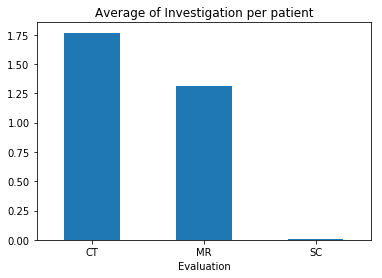

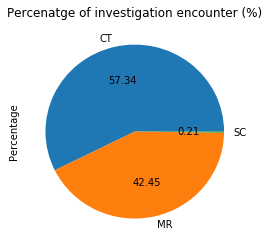

In [34]:
# --> b Ploting Bar chart
pd_df_5.plot.bar(x= 'Evaluation',y= 'Average_per_patient',rot = 0, 
               legend = False,
                title = 'Average of Investigation per patient'
                )


# --> c Ploting pie chart
pd_df_5.plot.pie(y= 'Percentage', figsize=(4,4),
               autopct='%.2f', legend = False,
               labels = ['CT','MR','SC'],
                title = 'Percenatge of investigation encounter (%)')

#### Step 3 :- Saving the solution as .csv file

In [ ]:
filename_5 = "/home/cloudera/Desktop/assignment/data_result_df/DF_5.csv"
pd_df_5.to_csv(filename_5, index = False, header = True)

###  Statement 6 :- The client would like to know the year group (i.e. you will need to group the ages of encounter into years) which is given the greatest number of CTs. (DF)

#### 6.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Filtering the dataframe to retain only CT
* Step2:- Dropping duplicates
* Step3:- Convert the age from decimal to int. -> float age -> int age.
* Step2:- Select only patient_id and 
* Step3:- Sorting by year group in Ascending order


In [35]:
import pyspark.sql.functions as func

#### Step 1:- Filtering to retain only 'CT'

In [36]:
imaging_CT_df = imaging_df.where('modality = "CT"')

#### Step 2 :- Drop Duplicates
The intenstion was to not account for a patient that has been evaluated at the same time with CT.
However the duplicates is not present in tha table since the presence of primary key ('patient_id','imaging_age','modality') doesnot allow duplicates.
This is a validation check on dataframe since dropping of duplicates is a straightforward syntax in DF

In [37]:
imagingCT_noDuplicates = imaging_CT_df.dropDuplicates()

VALIDATION

In [38]:
print 'Without dropping the duplicates',imaging_CT_df.count()
print 'With dropping the duplicates',imagingCT_noDuplicates.count()

Without dropping the duplicates 1911
With dropping the duplicates 1911


#### Step 3:- Converting age to int

In [39]:
imaging_CTyeargroup_df = imagingCT_noDuplicates.withColumn("Year_group", imaging_df.imaging_age.cast('int'))
imaging_ct_records = imaging_CTyeargroup_df.count()

#### Step 5:- Select only patient_id and imaging_age

In [40]:
imaging_yeargroup_CT_count = imaging_CTyeargroup_df.select('Year_group','modality').groupby('Year_group').count().sort(col("count").desc())
#imaging_yeargroup_CT_count.show(5)  # --> [year_group, modality_count]  
#CT_count = imaging_yeargroup_df.select('Year_group','modality').where('modality = "CT"').count()

#### Step 6:-Sorting by year group

In [41]:
df_6 = imaging_yeargroup_CT_count.sort(col("Year_group"))
df_6.show(5)  # --> [year_group, modality_count]

+----------+-----+
|Year_group|count|
+----------+-----+
|         0|  160|
|         1|   94|
|         2|  213|
|         3|  210|
|         4|   81|
+----------+-----+
only showing top 5 rows



#### 6.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe (line graph)
* Step 3:-Saving the solutions in pandas df to csv file

#### Step 1:- Creating Pandas Dataframe

In [42]:
pd_df_6 = df_6.toPandas()
pd_df_6

,Year_group,count
0,0,160
1,1,94
2,2,213
3,3,210
4,4,81
5,5,202
6,6,66
7,7,115
8,8,119
9,9,95


#### Step 2:-  Plot line chart

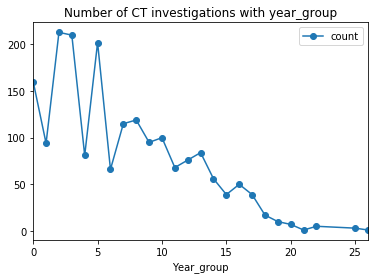

In [43]:
viz_6 = pd_df_6.plot(
    x='Year_group', linestyle='-', marker='o',
    figsize = (6,4),
    title = 'Number of CT investigations with year_group')
viz_6

#### Step 3 :-  Saving the solution as .csv file

In [44]:
filename_6 = "/home/cloudera/Desktop/assignment/data_result_df/DF_6.csv"
pd_df_6.to_csv(filename_6, index = False, header = True)

In [45]:
#===========================================================
# To check the datatype of each column 
# https://stackoverflow.com/questions/45033315/get-datatype-of-column-using-pyspark
#===========================================================
import pandas as pd
pd.set_option('max_colwidth', -1) # to prevent truncating of columns in jupyter

def count_column_types(spark_df):
    """Count number of columns per type"""
    return pd.DataFrame(spark_df.dtypes).groupby(1, as_index=False)[0].agg({'count':'count', 'names': lambda x: " | ".join(set(x))}).rename(columns={1:"type"})

count_column_types(imaging_df)

,type,count,names
0,double,1,imaging_age
1,string,2,modality | patient_id


###  Statement 7 :- For each year group, the client would like to visualize the most frequent diagnosis code (with its frequency). (DF)

#### 7.1 DATA ANALYSIS
Approach adapted:-
* Step1:- Convert the age from decimal to int.
* Step2:- Finding diagnosis_code count for each diagnosis_code and year_age ( df_a) 
* Step3:- Finding maximum code count for each year group (df_b).
* Step4:- Inner join (df_a) and (df_b) where code_count = max_code_count & year_group = year_group
--> [Year_group, diagnosis_code, mx_count]

In [46]:
import pyspark.sql.functions as F
from pyspark.sql.functions import count, col
from pyspark.sql import Row

#### Step 1:- Converting the age from decimal to int

In [47]:
df_7_1 = diagnoses_df.withColumn("Year_group", diagnoses_df.diagnosis_age.cast('int'))
df_7_1.show(5)

+----------+--------------+----------------+----------+
|patient_id|diagnosis_code|   diagnosis_age|Year_group|
+----------+--------------+----------------+----------+
| 00008RINR|    315.320000|2.18430371791803|         2|
| 00008RINR|    315.320000|2.80033330216659|         2|
| 00008RINR|    315.320000| 2.8222365762732|         2|
| 00008RINR|    315.320000|5.64822705794013|         5|
| 00008RINR|    315.320000|5.68655778752176|         5|
+----------+--------------+----------------+----------+
only showing top 5 rows



#### Step 2:-  Counting the diagnosis_code for each age group and diagnosis_code

In [48]:
df_7_2 = df_7_1.groupby('diagnosis_code','Year_group').agg(count('diagnosis_code').alias("code_count")).orderBy(col('Year_group').desc(),col('code_count').desc())
df_7_2.show(5)

+--------------+----------+----------+
|diagnosis_code|Year_group|code_count|
+--------------+----------+----------+
|    381.700000|        85|         6|
|        H69.00|        85|         6|
|        H66.90|        85|         4|
|    382.900000|        85|         4|
|         H90.6|        85|         3|
+--------------+----------+----------+
only showing top 5 rows



#### Step 3:- Selecting Year_group and code count

In [49]:
df_7_3 = df_7_2.select('Year_group','code_count')
df_7_3.show(5)

+----------+----------+
|Year_group|code_count|
+----------+----------+
|        85|         6|
|        85|         6|
|        85|         4|
|        85|         4|
|        85|         3|
+----------+----------+
only showing top 5 rows



#### Step 4 :- Finding maximum code count for each year_group
*      a. Output as RDD
*      b. Converting from RDD to Dataframe

In [50]:
RDD_7_1 = df_7_3.groupby('Year_group').max('code_count').withColumnRenamed('max(code_count)', 'max_code_count_by_Year_group').sort(col("max_code_count_by_Year_group").desc())
#RDD_7_1.take(10)

df_7_4 = RDD_7_1.toDF('Year_group','max_code_count_by_Year_group')
df_7_4.show(5)

+----------+----------------------------+
|Year_group|max_code_count_by_Year_group|
+----------+----------------------------+
|         0|                      148071|
|         2|                       72800|
|         1|                       54298|
|         3|                       48738|
|         5|                       40079|
+----------+----------------------------+
only showing top 5 rows



#### Step 5 :-  Inner join (condition: year_group and code_count)
NOTES
 * There are many negative year_groups, which might refer to evaluation been done when the patient
 is in the whomb of the mother. However, further investigation must be conducted to understand 
 its true meaning. For analysis and visualisation, the negative ages have been filtered out.


In [51]:
df_7_5 = df_7_4.join(df_7_2,[(df_7_4.Year_group == df_7_2.Year_group) & (df_7_4.max_code_count_by_Year_group == df_7_2.code_count)], how = "inner").drop(df_7_4.Year_group).orderBy(col('Year_group'),col('code_count').desc())
RDD_7_2 = df_7_5.drop(df_7_5.max_code_count_by_Year_group).where('Year_group >= 0')
df_7_6 = RDD_7_2.toDF('diagnosis_code','Year_group','code_count')
df_7_6.show(5)

+--------------+----------+----------+
|diagnosis_code|Year_group|code_count|
+--------------+----------+----------+
|         V20.2|         0|    148071|
|         V20.2|         1|     54298|
|    382.900000|         2|     72800|
|         V20.2|         3|     48738|
|    382.900000|         4|     12547|
+--------------+----------+----------+
only showing top 5 rows



#### 7.2 DATA VISUALISATION
Approach: 
* Step 1:-Creating pandas dataframe
* Step 2:-Plotting from pandas dataframe
* Step 3:-Saving the solutions in pandas df to csv file
* Step 4:-Plotting the bar graphs using multiple age range 

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Step 1:- Converting the existing spark df to pandas df

In [53]:
pandas_df_7 = df_7_6.toPandas()
pandas_df_7

,diagnosis_code,Year_group,code_count
0,V20.2,0,148071
1,V20.2,1,54298
2,382.900000,2,72800
3,V20.2,3,48738
4,382.900000,4,12547
5,V20.2,5,40079
6,381.810000,6,7526
7,V20.2,7,17284
8,V20.2,8,17314
9,V20.2,9,14998


#### Step 2:- Visualisation using plots (using full data)

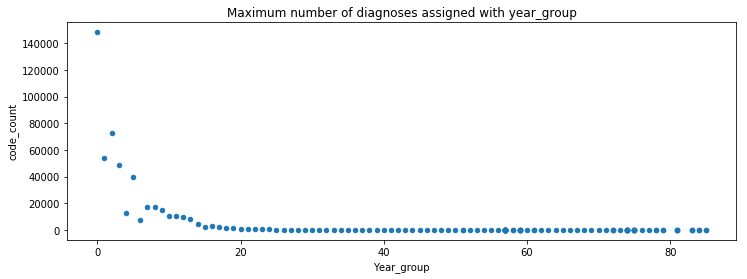

In [54]:
viz_7_1 = pandas_df_7.plot.scatter (x = 'Year_group',
                           y = 'code_count',
                             figsize=(12,4),
                             title = 'Maximum number of diagnoses assigned with year_group')
viz_7_1

#### Step 3 :- Saving the solution as .csv file

In [ ]:
filename_7 = "/home/cloudera/Desktop/assignment/data_result_df/DF_7.csv"
pandas_df_7.to_csv(filename_7, index = False, header = True)

##### Definition 7.1.1 DF
* For creating dataframes based on inout age range

In [55]:
#-------------- Definition 7.1.1 DF -----------
def age_filter_1(pandas_df,age) :
    bol_age_df = pandas_df['Year_group'] >= age
    age_df = pandas_df[bol_age_df]
    return (age_df)

def age_filter_2(pandas_df,age1,age2):
    bol_age1_df = pandas_df['Year_group'] >= age1
    bol_age2_df = pandas_df['Year_group'] <= age2
    age_df = pandas_df[bol_age1_df & bol_age2_df ]
    return age_df

def age_filter_3(pandas_df,age) :
    bol_age_df = pandas_df['Year_group'] <= age
    age_df = pandas_df[bol_age_df]
    return (age_df)

#### Step 4:- Create smaller dataframes based on age range using definition 7.1.1

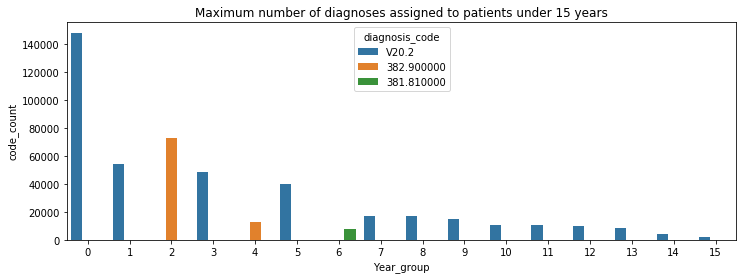

In [56]:
# --> a.ii Under 15 years
under15years = age_filter_2(pandas_df_7,0,15)

# --> Plot graph
plt.figure(figsize=(12, 4))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=under15years
           ).set_title("Maximum number of diagnoses assigned to patients under 15 years");


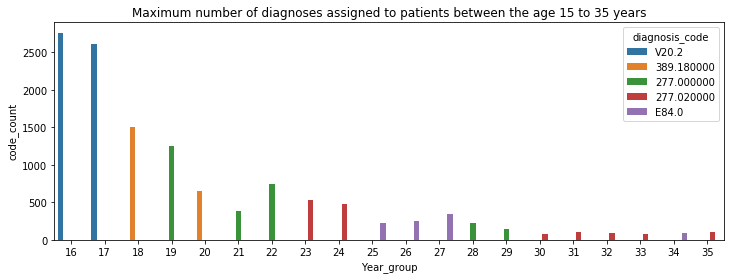

In [57]:
# --> a.iii 15 to 35 years
Age15to35 = age_filter_2(pandas_df_7,16,35)

plt.figure(figsize=(12, 4))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age15to35
           ).set_title("Maximum number of diagnoses assigned to patients between the age 15 to 35 years");


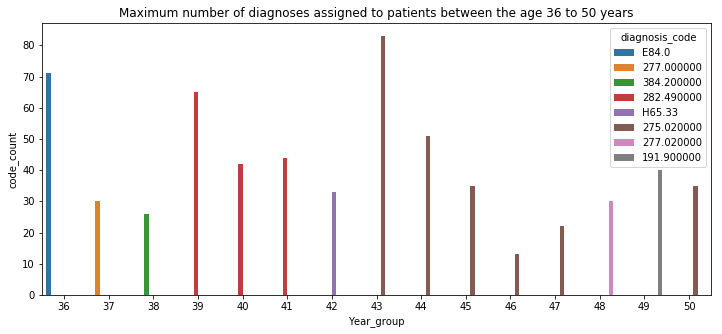

In [58]:
# --> a.iv 36 to 50 years
Age36to50 = age_filter_2(pandas_df_7,36,50)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age36to50
           ).set_title("Maximum number of diagnoses assigned to patients between the age 36 to 50 years");


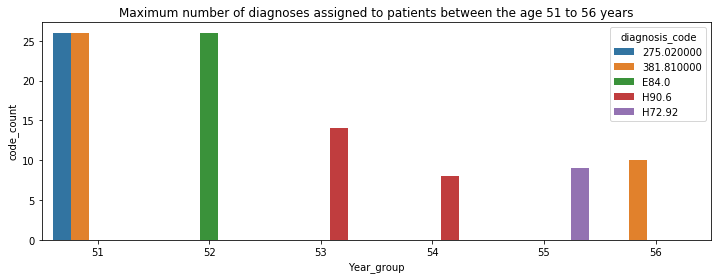

In [59]:
# --> a.v 51 to 56 years
Age51to56 = age_filter_2(pandas_df_7,51,56)
#print(Age25to34)

plt.figure(figsize=(12, 4))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age51to56
           ).set_title("Maximum number of diagnoses assigned to patients between the age 51 to 56 years");

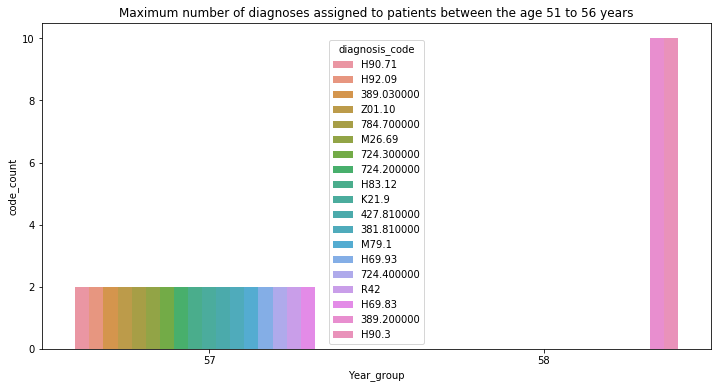

In [60]:
# --> a.v 57 to 58 years
Age57to58 = age_filter_2(pandas_df_7,57,58)
#print(Age25to34)

plt.figure(figsize=(12, 6))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age57to58
           ).set_title("Maximum number of diagnoses assigned to patients between the age 51 to 56 years");

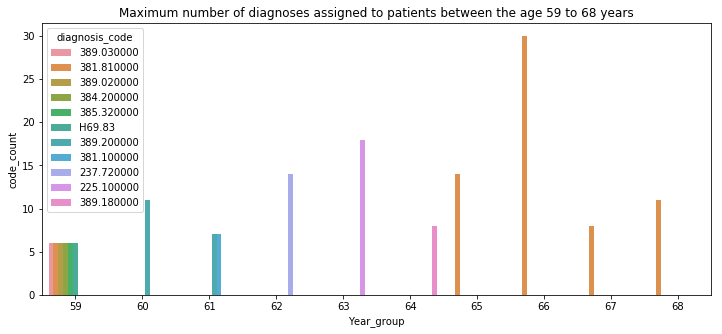

In [61]:
# --> a.vii 59 to 68 years
Age59to68 = age_filter_2(pandas_df_7,59,68)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age59to68
           ).set_title("Maximum number of diagnoses assigned to patients between the age 59 to 68 years");


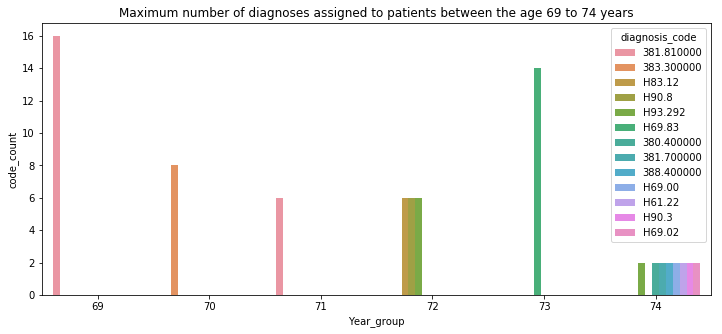

In [62]:
# --> a.vii 69 to 74 years
Age69to74 = age_filter_2(pandas_df_7,69,74)
#print(Age69to74)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Age69to74
           ).set_title("Maximum number of diagnoses assigned to patients between the age 69 to 74 years");


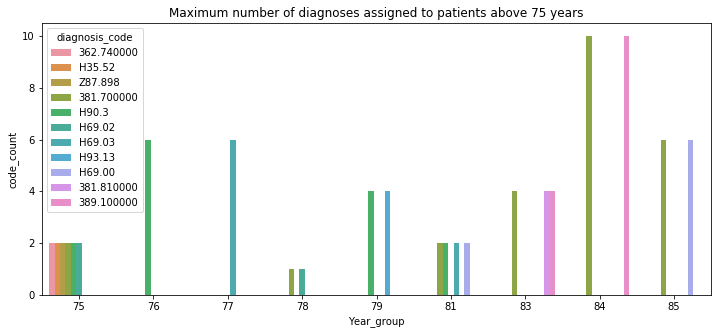

In [63]:
# --> a.ix Above 75 years
Above75years = age_filter_1(pandas_df_7,75)

plt.figure(figsize=(12, 5))
sns.barplot(x="Year_group", y="code_count",
            hue="diagnosis_code",
            data=Above75years
           ).set_title("Maximum number of diagnoses assigned to patients above 75 years");# --> a.ix Above 75 years


In [ ]:
# ======================================
#   Uncomment to visualise pandas dataframe
# ======================================

#DF7_7_Under15years
#DF7_7_Age15to35
#DF7_7_Age36to50 
#DF7_7_Age51to56
#DF7_7_Age57to58
#DF7_7_Age69to74 
#DF7_7_Above75years